# Wilt

Dataset is from https://archive.ics.uci.edu/dataset/285/wilt

n = 4839

5 features

In [6]:
import pandas as pd

In [7]:
url = "https://raw.githubusercontent.com/maxxxxc/SIR-Summer-2023/main/dataset/Wilt%20Dataset.csv"
df = pd.read_csv(url, header = None)

In [8]:
df.shape

(4839, 6)

In [9]:
print(df.head())

   0           1           2           3           4          5
0  1  120.362774  205.500000  119.395349  416.581395  20.676318
1  1  124.739583  202.800000  115.333333  354.333333  16.707151
2  1  134.691964  199.285714  116.857143  477.857143  22.496712
3  1  127.946309  178.368421   92.368421  278.473684  14.977453
4  1  135.431548  197.000000  112.690476  532.952381  17.604193


In [11]:
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
X = df.drop(0, axis=1)
y = df[0]

In [13]:
X.head()

,1,2,3,4,5
0,120.362774,205.500000,119.395349,416.581395,20.676318
1,124.739583,202.800000,115.333333,354.333333,16.707151
2,134.691964,199.285714,116.857143,477.857143,22.496712
3,127.946309,178.368421,92.368421,278.473684,14.977453
4,135.431548,197.000000,112.690476,532.952381,17.604193


In [14]:
y.value_counts()

0    4578
1     261
Name: 0, dtype: int64

In [15]:
#y = y.replace({"neg" : 0, "pos" : 1})
y.value_counts()

0    4578
1     261
Name: 0, dtype: int64

## Logistic Regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create and train the logistic regression model
#model = LogisticRegression()
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_train_pred)
print("Test Accuracy:", accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9707199448846021
Test Accuracy: 0.9659090909090909


# Divide and Conquer

Divide the training data into 11 batches, train a logistic model on each of the batch, and then combine the 11 prediction results. Consider the following two ensemble methods:
- majority voting
- average (or sum) of the logit output and then make decision based on its sign

In [17]:
def iterate_process(X, y):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # Define the number of batches
    num_batches = 11
    
    # Randomly shuffle the data indices
    #indices = np.random.permutation(len(X))
    
    #change 7/12
    indices = np.random.permutation(len(X_train))
    
    # Calculate the batch size
    batch_size = len(X_train) // num_batches
    
    # Make predictions on the test set using majority voting
    preds_voting = np.zeros(len(y_test))
    # Make predictions on the test set using average of logit
    preds_logit = np.zeros(len(y_test))
    #Make predictions on the test set using average of probs
    preds_prob = np.zeros(len(y_test))
    
    preds_voting_weighted = np.zeros(len(y_test))
    preds_logit_weighted = np.zeros(len(y_test))
    preds_prob_weighted = np.zeros(len(y_test))
    
    total_cverr = 0
    
    # Split the training data into batches, fit a logistic regression model on each batch
    for i in range(num_batches):
        # Calculate the starting and ending indices for the current batch
        start_index = i * batch_size
        end_index = (i + 1) * batch_size
        
        # Create a logistic regression model
        model = LogisticRegression(max_iter=500)
        
        # Select the current batch for training
        #X_batch = X_train[start_index:end_index]
        #y_batch = y_train[start_index:end_index]
        
        #change 7/12
        X_batch = X_train.iloc[indices[start_index:end_index]]
        y_batch = y_train.iloc[indices[start_index:end_index]]
        
        scaler = StandardScaler()
        X_batch_scaled = scaler.fit_transform(X_batch)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit the model on the current batch
        model.fit(X_batch_scaled, y_batch)
        current_cverr = cross_val_score(model, X_batch_scaled, y_batch, cv = 5, scoring = 'accuracy').mean()
        total_cverr += current_cverr
               
        y_pred = model.predict(X_test_scaled)
        # Accumulate the predictions using majority voting
        preds_voting += (y_pred == 1)
        preds_voting_weighted += (y_pred == 1) * current_cverr
    
        # Accumulate the predictions using majority voting
        y_pred = model.decision_function(X_test_scaled)
        preds_logit += y_pred
        preds_logit_weighted += y_pred * current_cverr
        
        #Accumulate the probs
        y_pred = model.predict_proba(X_test_scaled)
        preds_prob += y_pred[:,1]
        preds_prob_weighted += y_pred[:,1] * current_cverr
    
    accuracy = np.zeros(7)
    auc_accuracy = np.zeros(7)
    
    preds_voting_weighted = preds_voting_weighted / total_cverr * num_batches
    preds_logit_weighted = preds_logit_weighted / total_cverr * num_batches
    preds_prob_weighted = preds_prob_weighted / total_cverr * num_batches
    
    # Majority voting (selecting the most frequent prediction for each sample)
    final_predictions = np.where(preds_voting > num_batches / 2, 1, 0)
    accuracy[0] = accuracy_score(y_test, final_predictions)
    auc_accuracy[0] = roc_auc_score(y_test, preds_voting)
    
    final_predictions = np.where(preds_voting_weighted > num_batches / 2, 1, 0)
    accuracy[1] = accuracy_score(y_test, final_predictions)
    auc_accuracy[1] = roc_auc_score(y_test, preds_voting_weighted)
    
    # Average of logit
    final_predictions = np.where(preds_logit > 0, 1, 0)
    accuracy[2] = accuracy_score(y_test, final_predictions)
    auc_accuracy[2] = roc_auc_score(y_test, preds_logit)
    
    final_predictions = np.where(preds_logit_weighted > 0, 1, 0)
    accuracy[3] = accuracy_score(y_test, final_predictions)
    auc_accuracy[3] = roc_auc_score(y_test, preds_logit_weighted)
    
    #Average of probs
    final_predictions = np.where(preds_prob / num_batches > 0.5, 1, 0)
    accuracy[4] = accuracy_score(y_test, final_predictions)
    auc_accuracy[4] = roc_auc_score(y_test, preds_prob)
    
    final_predictions = np.where(preds_prob_weighted / num_batches > 0.5, 1, 0)
    accuracy[5] = accuracy_score(y_test, final_predictions)
    auc_accuracy[5] = roc_auc_score(y_test, preds_prob_weighted)
    
    # Train a model on all 11 batches of training data
    model = LogisticRegression(max_iter=500)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy[6] = accuracy_score(y_test, y_pred)
    y_pred = model.decision_function(X_test_scaled)
    auc_accuracy[6] = roc_auc_score(y_test, y_pred)
    
    return accuracy, auc_accuracy

Try the divide and conquer approaches 10 times, reporting the following error matrix. 
- 10-by-4
- col_1: majority voting
- col_2: average the logit
- col_3: average probabilities
- col_4: using the model trained on all the training data

In [19]:
# Number of times to repeat the process
num_repeats = 50

#stripplot
methods = ['MV', 'WMV', 'LA', 'WLA', 'PA', 'WPA', 'default'] 
method_names= [method for method in methods for _ in range(num_repeats)]

# Initialize an empty matrix (10-by-4) to store accuracies
accuracies = np.zeros((num_repeats, 7))
auc_accuracies = np.zeros((num_repeats, 7))



seed = 42
# Repeat the process and store accuracies
for i in range(num_repeats):
    np.random.seed(seed)
    accuracies[i], auc_accuracies[i] = iterate_process(X, y)
    seed += 2
    
#stripplot  
data = {'accuracies': accuracies.flatten(), 'methods' : method_names}
df = pd.DataFrame(data)
    

# Print the accuracies
print("Accuracies:", accuracies)
print("AUC:", auc_accuracies)

Accuracies: [[0.95041322 0.95041322 0.95041322 0.95041322 0.95041322 0.95041322
  0.9571281 ]
 [0.95299587 0.95299587 0.95299587 0.95299587 0.95299587 0.95299587
  0.96022727]
 [0.94834711 0.94834711 0.94834711 0.94834711 0.94834711 0.94834711
  0.95661157]
 [0.93853306 0.93853306 0.93853306 0.93853306 0.93853306 0.93853306
  0.94731405]
 [0.9375     0.9375     0.9375     0.9375     0.9375     0.9375
  0.94834711]
 [0.94369835 0.94369835 0.94369835 0.94369835 0.94369835 0.94369835
  0.95299587]
 [0.94576446 0.94576446 0.94576446 0.94576446 0.94576446 0.94576446
  0.95506198]
 [0.94163223 0.94163223 0.94163223 0.94163223 0.94163223 0.94163223
  0.9535124 ]
 [0.95144628 0.95144628 0.95144628 0.95144628 0.95144628 0.95144628
  0.95971074]
 [0.94628099 0.94628099 0.94628099 0.94628099 0.94628099 0.94628099
  0.9535124 ]
 [0.95247934 0.95247934 0.95196281 0.95247934 0.95247934 0.95247934
  0.96177686]
 [0.95092975 0.95092975 0.95092975 0.95092975 0.95092975 0.95092975
  0.95557851]
 [0.9436

In [20]:
np.mean(accuracies, axis = 0)

array([0.94579545, 0.94579545, 0.94581612, 0.94582645, 0.94582645,
       0.94582645, 0.95411157])

In [21]:
np.std(accuracies, axis = 0)

array([0.00434181, 0.00434181, 0.00432684, 0.00434209, 0.00434209,
       0.00434209, 0.00479383])

In [22]:
np.mean(auc_accuracies, axis = 0)

array([0.51601713, 0.51599875, 0.92466141, 0.92445634, 0.92616691,
       0.92597825, 0.97506038])

In [23]:
np.std(auc_accuracies, axis = 0)

array([0.01334285, 0.01332228, 0.01236512, 0.01240834, 0.01166745,
       0.01167591, 0.00499071])

C:\Users\panda\AppData\Local\Temp\ipykernel_2408\2593363950.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = 'methods', y = 'accuracies', data = df, jitter = 1, dodge = True, palette = 'Set1', size = 3)


<Axes: xlabel='methods', ylabel='accuracies'>

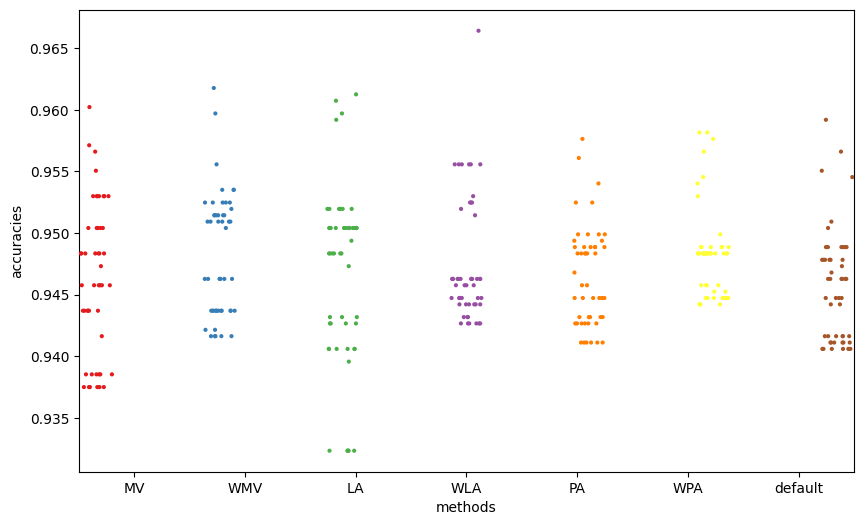

In [40]:
plt.figure(figsize = (10, 6))
sns.stripplot(x = 'methods', y = 'accuracies', data = df, jitter = 1, dodge = True, palette = 'Set1', size = 3)

In [28]:
df.size

700

In [43]:
df.head

<bound method NDFrame.head of      accuracies  methods
0      0.950413       MV
1      0.950413       MV
2      0.950413       MV
3      0.950413       MV
4      0.950413       MV
..          ...      ...
345    0.944215  default
346    0.944215  default
347    0.944731  default
348    0.944731  default
349    0.950930  default

[350 rows x 2 columns]>

In [41]:
method_names

['MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'MV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'WMV',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA',
 'LA'